In [15]:
import numpy as np
from numba import njit
from numpy.random import Generator, MT19937, SeedSequence
sq = SeedSequence(1234)
bit_generator = MT19937(sq)
gen = Generator(bit_generator)
for i in range(10):
    print(gen.random(1))
gen.integers(low=0,high=6,size=1)

[0.12038356]
[0.40370142]
[0.87770263]
[0.9565788]
[0.42646002]
[0.28304326]
[0.90094107]
[0.83083314]
[0.67528993]
[0.3977176]


array([5])

In [16]:
import numpy as np
import numba as nb
from numpy.random import PCG64
from timeit import timeit

bit_gen = PCG64()
next_d = bit_gen.cffi.next_double
state_addr = bit_gen.cffi.state_address

def rando(n, state):
    out = np.empty(n)
    for i in range(n):
        out[i]= next_d(state)
        
    return out

# Compile using Numba
randoj = nb.jit(rando, nopython=True)
# Must use state address not state with numba
n = 10**6

def numbacall():
    return randoj(n, state_addr)

rg = np.random.Generator(PCG64())

def numpycall():
    return rg.random(size=n)

# Check that the functions work
r1 = numbacall()
r2 = numpycall()
assert r1.shape == (n,)
assert r1.shape == r2.shape

t1 = timeit(numbacall, number=1)
print(f'{t1:.2f} secs for {n} PCG64 (Numba/PCG64) gaussian randoms')
t2 = timeit(numpycall, number=1)
print(f'{t2:.2f} secs for {n} PCG64 (NumPy/PCG64) gaussian randoms')


0.00 secs for 1000000 PCG64 (Numba/PCG64) gaussian randoms
0.00 secs for 1000000 PCG64 (NumPy/PCG64) gaussian randoms


In [82]:
import numpy as np
def correl(func,start,dist):
    N = (len(func)-start-dist)
    if (dist==0):
        return 1/N*np.sum(func[start:]**2)-np.sum(func[start:])**2/N**2
    else:
        return 1/N*np.sum(func[start:-dist]*func[start+dist:])-np.sum(func[start:-dist])**2/N**2

def autocorrel(func,start,dist):
    c_0 = correl(func,start,0)
    autocorr = 1/2
    cor = correl(func,start,1)/c_0
    iter =1
    while (cor>10**(-4)):
        autocorr += cor
        iter +=1
        cor = correl(func,start,iter)
    return autocorr

def correl_vec(func,start,comps):
    c_0 = correl(func,start,0)
    vec =np.zeros(comps)
    vec[0] = 1/2
    for i in range(1,comps):
        vec[i] = correl(func,start,i)/c_0
    return vec

In [19]:
def bootstrap(sample):
    n = len(sample)
    btstrp = np.zeros((n*np.log(n)**2))
    for i in range(n*np.log(n)**2):
        rand = randoj(n,state_addr)
        for pos in range(n):
            btstrp[pos] = sample[int(100*rand[pos])]
    return btstrp

def jackkknife(sample,cut_size,):
    jack_mat = np.zeros((len(sample)-cut_size+1,len(sample)-cut_size))
    for i in range(len(sample)-cut_size+1):
        jack_mat[i,0:i]= sample[0:i]
        jack_mat[i,i::] = sample[i+cut_size::]
    return jack_mat


def jack_mean(sample,cut_size):
    return np.mean(jackkknife(sample,cut_size),axis=1)

def jack_var(sample,cut_size):
    return np.std(jack_mean(sample,cut_size))

def bootstrap_mean(sample):
    mean_mat = np.mean(bootstrap(sample),axis=1)
    return np.std(mean_mat)




In [20]:
def reweighting(beta,beta0,obs,Ham):
    return np.sum(obs*np.exp(-(beta-beta0)*Ham))/np.sum(np.exp(-(beta-beta0)*Ham))
def error_reweight(beta,beta0,obs,Ham,jack_cut):
    obs_jack = jackkknife(obs,jack_cut)
    Ham_jack = jackkknife(Ham,jack_cut)
    jack_vals = np.zeros(obs_jack.shape[0])
    for i in range(obs_jack.shape[0]):
        jack_vals[i] = reweighting(beta,beta0,obs_jack[i],Ham_jack[i])
    return np.std(jack_vals), np.mean(jack_vals)

[18, 19, 24, 33]


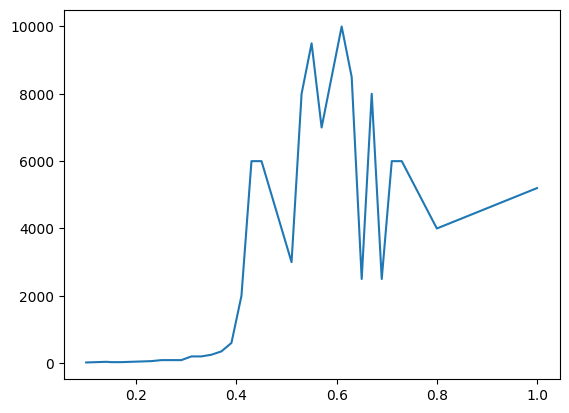

In [8]:
import matplotlib.pyplot as plt
start_pos = list(np.array([20,40,30,30,40,50,60,90,90,90,200,200,250,350,600,2000,6000,6000,50000,-1,3000,8000,9500,7000,-1,10000,8500,2500,8000,2500,6000,6000,4000,80000,5200]))

beta = list(np.zeros(35))
for i in range(30):
    beta[i+2]= 0.15 +0.6/30*i
for i in range(2):
    beta[i] = 0.1+0.04*i
for i in range(3):
    beta[i+32]= 0.8+ 0.1*i
indx = []
for i in range(35):
    if (start_pos[i]>10000 or start_pos[i]<0):
        indx.append(i)
print(indx)
i =0
while (i<len(start_pos)):
    if (start_pos[i]>10000 or start_pos[i]<0):
        del start_pos[i]
        del beta[i]
        i -=1
    i+=1

fig, ax = plt.subplots(1,1)
ax.plot(beta,start_pos)
plt.show()

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('mag_correl.txt',header= None,sep='\t')
print(data.shape)
data = data.to_numpy()

(35, 30002)


In [11]:
remeasured_data = pd.read_csv('Mag_store.txt',header= None,sep='\t')
print(remeasured_data.shape)
remeasured_data = remeasured_data.to_numpy()

(4, 300001)


In [52]:
data = data/128**2
remeasured_data = remeasured_data/128**2

In [79]:
with open("Mag_store.txt","w") as file:
    for i in range(35):
        for j in range(data.shape[1]):
            file.write("{}\t".format(data[i,j]))
        file.write("\n")

In [84]:
re_measured_start = np.array([6000,40000,140000,8000])
start_pos = np.array(start_pos)
components = 2000
cor_mat = np.zeros((len(start_pos),components))
for i in range(len(start_pos)):
    cor_mat[i,:] = correl_vec(data[i,:-2],start_pos[i],components)

remeasured_cor = np.zeros((4,components))
for i in range(4):
    remeasured_cor[i,:] = correl_vec(remeasured_data[i,:],re_measured_start[i],components)


In [83]:
correl(data[0,:-2],200,0)

3.391898021044564e-05

In [198]:
params = np.zeros(start_pos.shape[0])
fit_error = np.zeros(start_pos.shape[0])

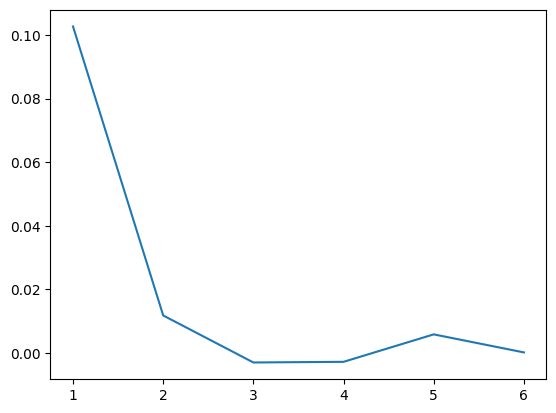

In [188]:
dist = np.arange(components)
end = 7
beta=0
fig, ax = plt.subplots(1,1)
ax.plot(dist[1:end],cor_mat[beta,1:end])
plt.show()

[2.27503457]


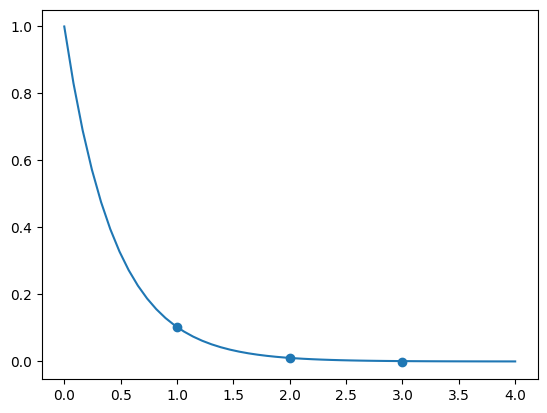

In [199]:
end = 4
from scipy.optimize import curve_fit
def exp_fit(x,b):
    return np.exp(-b*x)

param, error =curve_fit(f=exp_fit,xdata=dist[1:end],ydata=cor_mat[beta,1:end])
print(param)
params[beta] = param
fit_error[beta] = error
steps = np.linspace(0,end)
fig, ax = plt.subplots(1,1)
ax.scatter(dist[1:end],cor_mat[beta,1:end])
ax.plot(steps,exp_fit(steps,param))
plt.show()

In [200]:
params[0]*10

22.750345683470083